# Notebook Goal

Does the superclustering signal, in the way we're measuring it, depend on the mass of the central cluster in Websky?

In [14]:
import numpy as np
import os
from astropy.cosmology import Planck15 as cosmo, z_at_value
from astropy import units as u
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
import pickle
warnings.filterwarnings('ignore')
import coop_post_processing as cpp
import matplotlib as mpl
from PIL import Image
from scipy import ndimage

# set plot params
mpl.rc('text', usetex=False)
mpl.rcParams['figure.figsize'] = [6.0, 4.0]
mpl.rcParams['figure.dpi'] = 140

# mpl.rcParams['mathtext.fontset'] = 'stix'
# mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = '16'

In [2]:
def plot(im_array, rad_in_mpc):
    fig    = plt.figure(figsize=[8,5])
    smoothplot = plt.imshow(np.flipud(ndimage.gaussian_filter(im_array, sigma=8)), cmap='afmhot', vmin=-1e-7, vmax=6e-7)
#, vmax=3.5e-7, vmin=-1e-7
    locs = []
    for i in range(9):
        locs.append(i/8. * im_array.shape[0])

    labels = []
    mpc_per_pix = rad_in_mpc / (im_array.shape[0]//2)
    for loc in locs:
        labels.append(round((loc-im_array.shape[0]//2) * mpc_per_pix.value))

    plt.xlabel("x [cMpc]")
    plt.ylabel("y [cMpc]")
    plt.xticks(locs, labels)
    plt.yticks(locs, labels)

    cbar = fig.colorbar(smoothplot)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.set_label('Compton-$y$')
    cbar.update_ticks()
    return(None)
    
def plot_3(im_arr, rad_in_mpc):

    fig,ax = plt.subplots(ncols=3, nrows=1, figsize=[12,6])

    locs = []
    for i in range(5):
        locs.append(i/4. * im_arr[0].shape[0])

    labels = []
    mpc_per_pix = rad_in_mpc / (im_arr[0].shape[0]//2)

    for loc in locs[2:]:
        labels.append(round((loc-im_arr[0].shape[0]//2) * mpc_per_pix.value))
    for i in range(3):
        smthplot = ax[i].imshow(np.flipud(ndimage.gaussian_filter(im_arr[i], sigma=8)), cmap='afmhot', vmin=-5e-8, vmax=2e-7)
        ax[i].set_xticks(locs[2:])
        ax[i].set_xticklabels(labels)
        ylocs = list(reversed(locs))
        ax[i].set_yticks(ylocs[2:])
        ax[i].set_yticklabels(labels)
        ax[i].set_xlabel("x [cMpc]")

    ax[0].set_ylabel("y [cMpc]")
   
    cbar = fig.colorbar(smthplot, ax=ax, fraction=0.015, pad=0.04)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.set_label('Compton-$y$')
    cbar.update_ticks()
    return(None)


In [3]:
def getbinnedprofs(pkl,nreg):
    y_mean        = pkl['prof_allreg']
    y_mean_binned = pkl['binnedprof_allreg']
    binned_r      = pkl['binned_r']
    ys_all_regions = []
    for reg in range(nreg):
    #             y = websky_prof['profs_reg{:d}'.format(reg)][:,m]
        y = pkl['binnedprof_reg{:d}'.format(reg)][:,m]
        ys_all_regions.append(y)
    covmat, cormat = cpp.covariances(ys_all_regions, weights=np.ones(len(ys_all_regions)), nreg=nreg)
    errors = np.sqrt(np.diag(covmat))
    return(binned_r, y_mean_binned, cormat, errors)

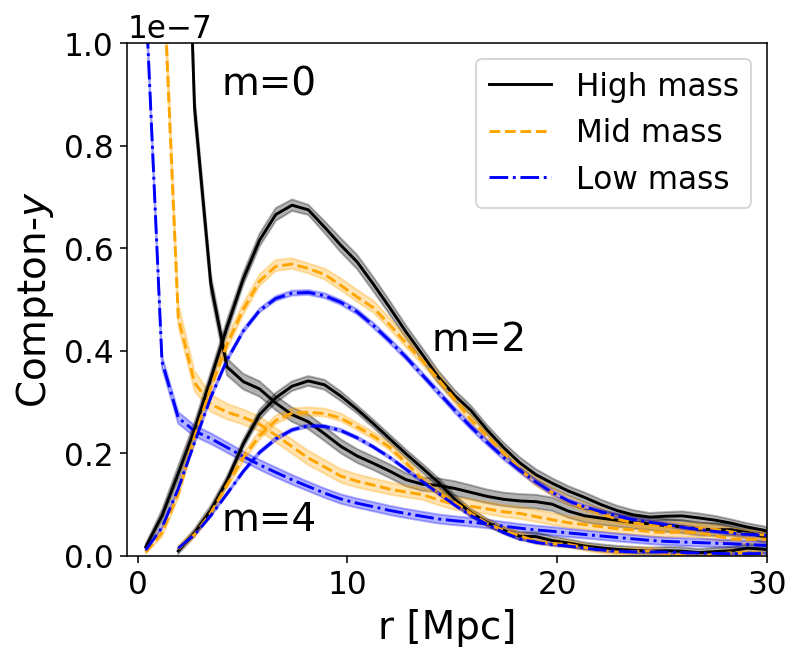

In [17]:
plt.figure(figsize=[6,5])
himass_c  = 'black'
midmass_c = 'orange'
lowmass_c = 'blue'
for m in [0,2,4]:
    himass  = pickle.load(open("/mnt/scratch-lustre/mlokken/stacking/PeakPatch_tSZ/fullsky/orient_by_1pt5E12_to_1E15_msun_halos/Websky_massgt1e+14_1232_1832Mpc_13pt9Mpc_smth_48reg_m0to5_profiles.pkl", "rb"))
    midmass = pickle.load(open("/mnt/scratch-lustre/mlokken/stacking/PeakPatch_tSZ/fullsky/orient_by_1pt5E12_to_1E15_msun_halos/Websky_massgt5e+13lt1e+14_1232_1832Mpc_13pt9Mpc_smth_48reg_m0to5_profiles.pkl", "rb"))
    lowmass = pickle.load(open("/mnt/scratch-lustre/mlokken/stacking/PeakPatch_tSZ/fullsky/orient_by_1pt5E12_to_1E15_msun_halos/Websky_massgt1e+13lt5e+13_1232_1832Mpc_13pt9Mpc_smth_48reg_m0to5_profiles.pkl", "rb"))
    binned_r_hi, y_mean_hi, cormat_hi, errs_hi = getbinnedprofs(himass, 48)
    binned_r_mid, y_mean_mid, cormat_mid, errs_mid = getbinnedprofs(midmass, 48)
    binned_r_lo, y_mean_lo, cormat_lo, errs_lo = getbinnedprofs(lowmass, 48)

    
    if m==0:
        plt.plot(binned_r_hi, y_mean_hi[:,m], label='High mass', linestyle='solid', color=himass_c)
        plt.fill_between(binned_r_hi, y_mean_hi[:,m]-errs_hi, y_mean_hi[:,m]+errs_hi, alpha = 0.3, color=himass_c)
        plt.plot(binned_r_mid, y_mean_mid[:,m], label='Mid mass', linestyle='dashed', color=midmass_c)
        plt.fill_between(binned_r_mid, y_mean_mid[:,m]-errs_mid, y_mean_mid[:,m]+errs_hi, alpha = 0.3, color=midmass_c)
        plt.plot(binned_r_lo, y_mean_lo[:,m], label='Low mass', linestyle='dashdot', color=lowmass_c)
        plt.fill_between(binned_r_lo, y_mean_lo[:,m]-errs_lo, y_mean_lo[:,m]+errs_lo, alpha = 0.3, color=lowmass_c)
    elif m==2:
        plt.plot(binned_r_hi, y_mean_hi[:,m], linestyle='solid', color=himass_c)
        plt.fill_between(binned_r_hi, y_mean_hi[:,m]-errs_hi, y_mean_hi[:,m]+errs_hi, alpha = 0.3, color=himass_c)
        plt.plot(binned_r_mid, y_mean_mid[:,m], linestyle='dashed', color=midmass_c)
        plt.fill_between(binned_r_mid, y_mean_mid[:,m]-errs_mid, y_mean_mid[:,m]+errs_hi, alpha = 0.3, color=midmass_c)
        plt.plot(binned_r_lo, y_mean_lo[:,m], linestyle='dashdot', color=lowmass_c)
        plt.fill_between(binned_r_lo, y_mean_lo[:,m]-errs_lo, y_mean_lo[:,m]+errs_lo, alpha = 0.3, color=lowmass_c)
    elif m==4:
        s = 2
        plt.plot(binned_r_hi[s:], y_mean_hi[:,m][s:], linestyle='solid', color=himass_c)
        plt.fill_between(binned_r_hi[s:], y_mean_hi[:,m][s:]-errs_hi[s:], y_mean_hi[:,m][s:]+errs_hi[s:], alpha = 0.3, color=himass_c)
        plt.plot(binned_r_mid[s:], y_mean_mid[:,m][s:], linestyle='dashed', color=midmass_c)
        plt.fill_between(binned_r_mid[s:], y_mean_mid[:,m][s:]-errs_mid[s:], y_mean_mid[:,m][s:]+errs_hi[s:], alpha = 0.3, color=midmass_c)
        plt.plot(binned_r_lo[s:], y_mean_lo[:,m][s:], linestyle='dashdot', color=lowmass_c)
        plt.fill_between(binned_r_lo[s:], y_mean_lo[:,m][s:]-errs_lo[s:], y_mean_lo[:,m][s:]+errs_lo[s:], alpha = 0.3, color=lowmass_c)

        
    plt.ylim([0,1e-7])


mpl.rcParams['font.size'] = '16'
plt.xlim([-0.5,30])
plt.xlabel("r [Mpc]", fontsize=20)
plt.ylabel("Compton-$y$", fontsize=20)
plt.text(14,.4e-7,"m=2", fontsize=20)
plt.text(4,.9e-7,"m=0", fontsize=20)
plt.text(4,.05e-7,"m=4", fontsize=20)
plt.legend()
plt.tight_layout()
plt.savefig("/home/mlokken/oriented_stacking/plots/websky_massbins_m024.png",dpi=300)
#     plt.show()
#     plt.clf()

In [5]:
himass['npks_total'], midmass['npks_total'], lowmass['npks_total']

(169316, 314389, 3017917)

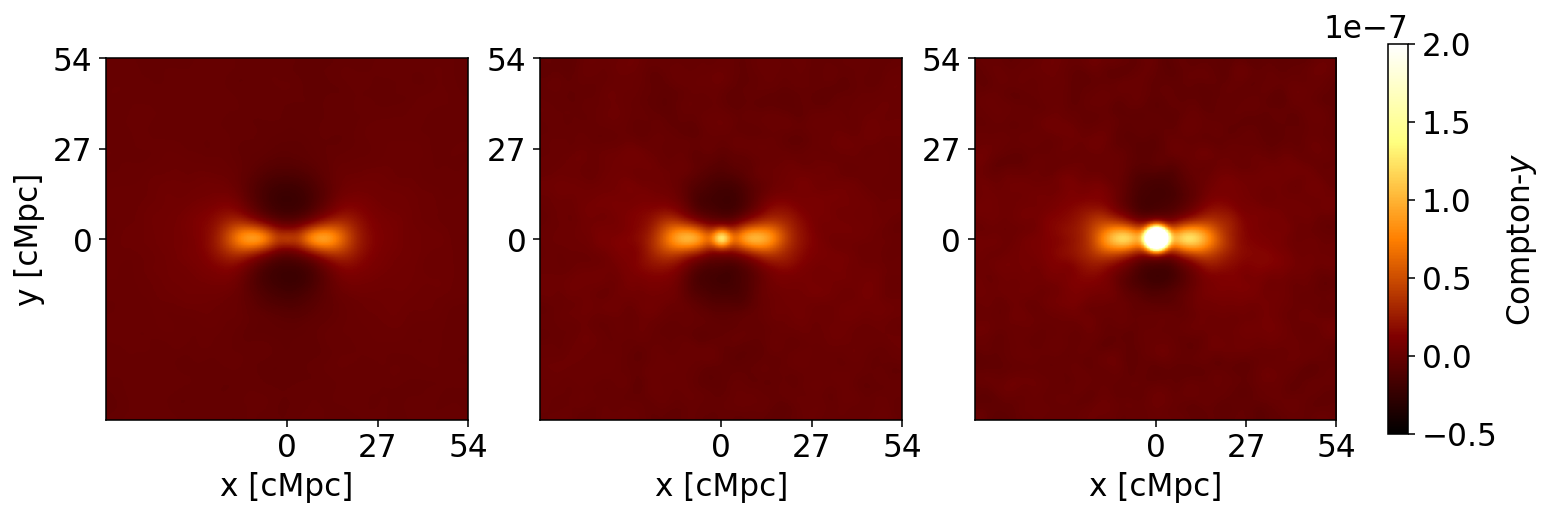

In [21]:
rad_in_Mpc = cosmo.kpc_comoving_per_arcmin(z_at_value(cosmo.comoving_distance,(1232+1832)/2.*u.Mpc)).to(u.Mpc/u.deg)*2*u.deg
hi_img  = np.loadtxt("/mnt/scratch-lustre/mlokken/stacking/PeakPatch_tSZ/fullsky/orient_by_1pt5E12_to_1E15_msun_halos/Websky_massgt1e+14_1232_1832Mpc_13pt9Mpc_smth_48regallreg_combined_stack.txt")
mid_img = np.loadtxt("/mnt/scratch-lustre/mlokken/stacking/PeakPatch_tSZ/fullsky/orient_by_1pt5E12_to_1E15_msun_halos/Websky_massgt5e+13lt1e+14_1232_1832Mpc_13pt9Mpc_smth_48regallreg_combined_stack.txt")
low_img = np.loadtxt("/mnt/scratch-lustre/mlokken/stacking/PeakPatch_tSZ/fullsky/orient_by_1pt5E12_to_1E15_msun_halos/Websky_massgt1e+13lt5e+13_1232_1832Mpc_13pt9Mpc_smth_48regallreg_combined_stack.txt")

plot_3([low_img,mid_img,hi_img],rad_in_Mpc)
plt.savefig("/home/mlokken/oriented_stacking/plots/3_massbins.png", dpi=300)

In [75]:
orienttype = 'HESSIAN'
symmetry   = 'SYMMETRIC'
smooth     = '17pt8Mpc'
emin       = '0pt1'
emax       = '2'
m          = 2
basepath_y = '/mnt/scratch-lustre/mlokken/stacking/PeakPatch_tSZ/fullsky/orient_by_2pt5E12_to_1pt6E13_msun_halos/'
basepath_pk= '/mnt/scratch-lustre/mlokken/stacking/PeakPatch_halomap/fullsky/orient_by_2pt5E12_to_1pt6E13_msun_halos/'
pk_path_him  = basepath_pk + 'lambda_gt_20/'# path to high-mass cluster results
stk_path_him = basepath_y + 'lambda_gt_20/'# path to high-mass cluster results
pk_path_medm  = basepath_pk + 'lambda_15_to_20/'
stk_path_medm  = basepath_y + 'lambda_15_to_20/'
pk_path_lowm  = basepath_pk + 'lambda_10_to_15/'
stk_path_lowm  = basepath_y + 'lambda_10_to_15/'

h_info_lowm = '/mnt/scratch-lustre/mlokken/pkpatch/downloaded_sep_25/halos_to_stack/fullsky/lambda_10_to_15/'
h_info_midm = '/mnt/scratch-lustre/mlokken/pkpatch/downloaded_sep_25/halos_to_stack/fullsky/lambda_15_to_20/'
h_info_him  = '/mnt/scratch-lustre/mlokken/pkpatch/downloaded_sep_25/halos_to_stack/fullsky/lambda_gt_20/'
dlow       = 1032
slice_wid  = 200
nstack     = 5

In [76]:
stacks_him  = []
stacks_medm = []
stacks_lowm = []
sumpks_him  = 0
sumpks_medm = 0
sumpks_lowm = 0
mass_lowm = []
mass_midm = []
mass_him  = []
for i in range(dlow, dlow+slice_wid*(nstack), slice_wid):
    slice_strt  = i
    slice_end   = i + slice_wid
    slice_mid   = (slice_strt + slice_end)
    stackfile   = 'stacks/pkptSZ_halo_{0}_{1}on{2}_smth_pkphalo_{3}to{4}Mpc_stack_e{5}to{6}on{2}_smth.fits'.format(orienttype, symmetry, smooth, slice_strt, slice_end, emin, emax)
    pkfile      = 'peaks/pkphalo_halo_{0}_{1}on{2}_smth_pkphalo_{3}to{4}Mpc_e{5}to{6}on{2}_smth.fits'.format(orienttype, symmetry, smooth, slice_strt, slice_end, emin, emax)
    hdr_him, img_him, npks_him = cpp.get_img(stk_path_him+stackfile, pk_path_him+pkfile)
    hdr_medm, img_medm, npks_medm = cpp.get_img(stk_path_medm+stackfile, pk_path_medm+pkfile)
    hdr_lowm, img_lowm, npks_lowm = cpp.get_img(stk_path_lowm+stackfile, pk_path_lowm+pkfile)
    if sumpks_him==0:
        # only check one time, same for all
        radius_deg = float(hdr_him['RADIUS'][1:])*u.deg
        res        = float(hdr_him['RES'][1:])
        arcmin_per_pix = radius_deg.to(u.arcmin) / res
    stacks_him.append(img_him)
    stacks_medm.append(img_medm)
    stacks_lowm.append(img_lowm)
    sumpks_him += npks_him
    sumpks_medm += npks_medm
    sumpks_lowm += npks_lowm
    
    mass_lowm.append(np.loadtxt(h_info_lowm+"fullinfo_lambda_10_to_15_distMpc_{:d}_{:d}.txt".format(slice_strt,slice_end))[:,0])
    mass_midm.append(np.loadtxt(h_info_midm+"fullinfo_lambda_15_to_20_distMpc_{:d}_{:d}.txt".format(slice_strt,slice_end))[:,0])
    mass_him.append(np.loadtxt(h_info_him+"fullinfo_lambda_20_to_200_distMpc_{:d}_{:d}.txt".format(slice_strt,slice_end))[:,0])
    

multi_stack_img_him, rad_in_mpc = cpp.stack_multi(stacks_him, dlow, slice_wid, arcmin_per_pix)
multi_stack_img_medm, rad_in_mpc = cpp.stack_multi(stacks_medm, dlow, slice_wid, arcmin_per_pix)
multi_stack_img_lowm, rad_in_mpc = cpp.stack_multi(stacks_lowm, dlow, slice_wid, arcmin_per_pix)

In [77]:
# get masses
mass_lowm = np.concatenate(mass_lowm)
mass_midm = np.concatenate(mass_midm)
mass_him = np.concatenate(mass_him)
lowm_minmass = np.amin(mass_lowm)
midm_minmass = np.amin(mass_midm)
him_minmass  = np.amin(mass_him)
lowm_maxmass = np.amax(mass_lowm)
midm_maxmass = np.amax(mass_midm)
him_maxmass  = np.amax(mass_him)

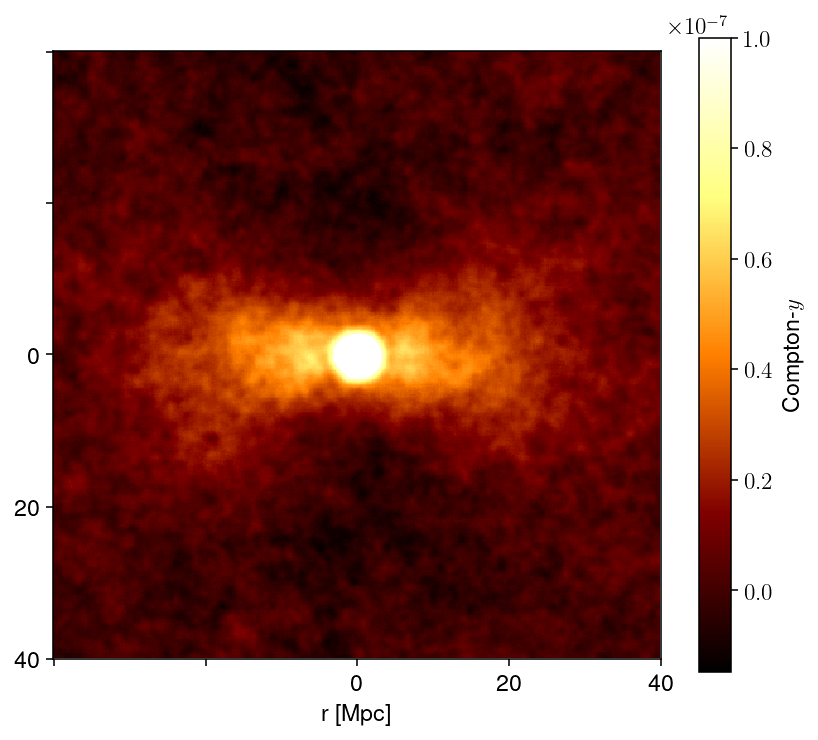

In [146]:
plot(multi_stack_img_him)
plt.savefig("/home/mlokken/actxdes_stacking/plots/lgt20_halos_tszonrmcm.png")



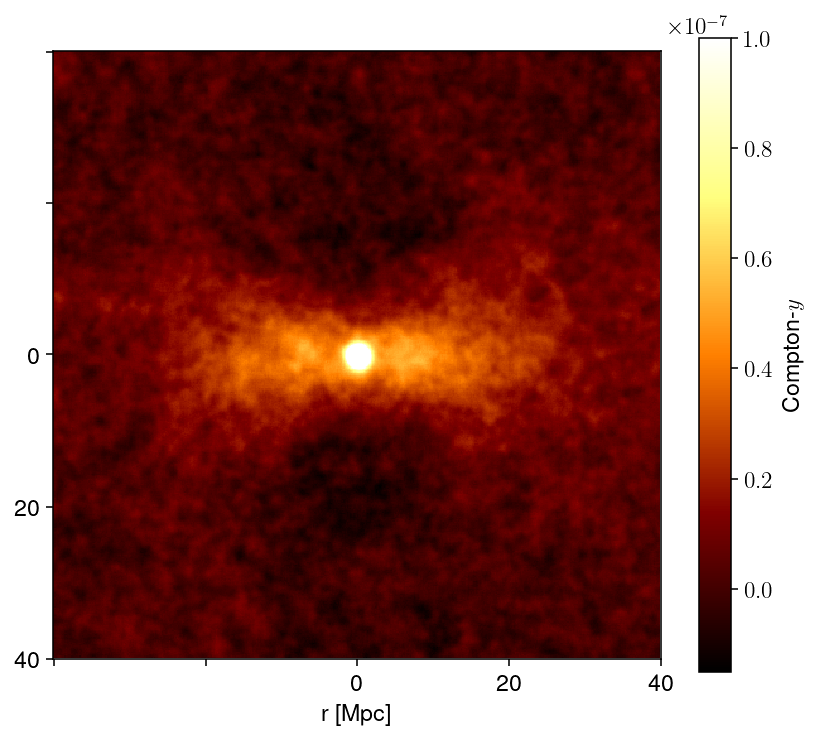

In [147]:
plot(multi_stack_img_medm)
plt.savefig("/home/mlokken/actxdes_stacking/plots/l15to20_halos_tszonrmcm.png")

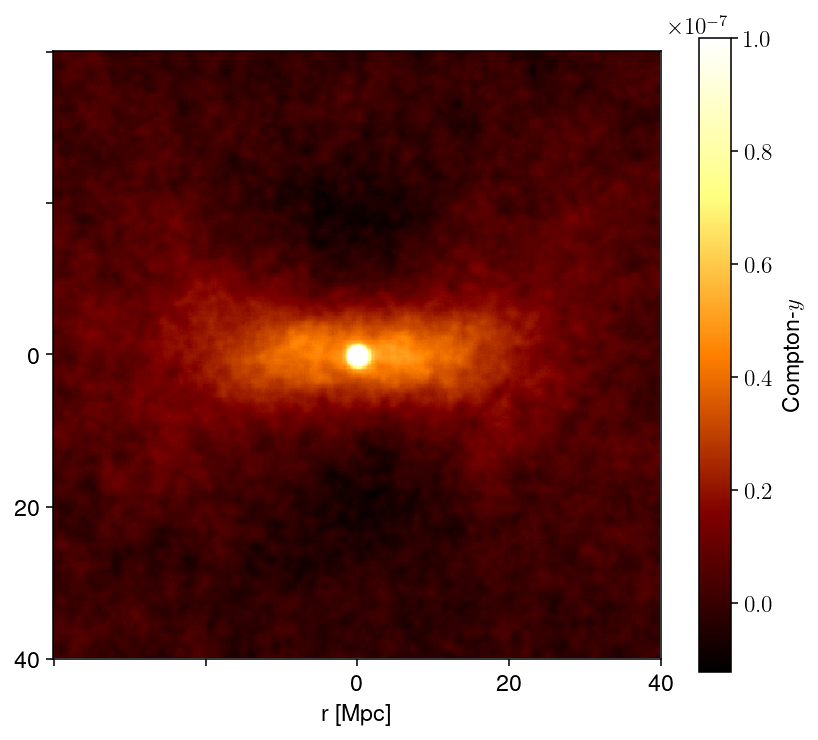

In [148]:
plot(multi_stack_img_lowm)
plt.savefig("/home/mlokken/actxdes_stacking/plots/l10to15_halos_tszonrmcm.png")

In [81]:
r_hi, Cr_hi, Sr_hi = cpp.radial_decompose_2D(multi_stack_img_him, 4)
r_med, Cr_med, Sr_med = cpp.radial_decompose_2D(multi_stack_img_medm, 4)
r_low, Cr_low, Sr_low = cpp.radial_decompose_2D(multi_stack_img_lowm, 4)

In [82]:
def bin_profile(Cr_m, arcmin_per_pix, binsize):
    binsize = binsize * u.arcmin
    arcmin_per_pix = arcmin_per_pix * u.arcmin
    pix_per_bin = binsize / arcmin_per_pix
    binned_y = []
    rad_in_pix = len(Cr_m)
    nbins = rad_in_pix / pix_per_bin
    for i in range(int(nbins)):
        start = i*4
        stop  = i*4 + 4
        binned_y.append(np.mean(Cr_m[start:stop]))
    r = np.arange(len(binned_y))
    step_in_mpc = rad_in_mpc/len(r)
    return binned_y, r*step_in_mpc


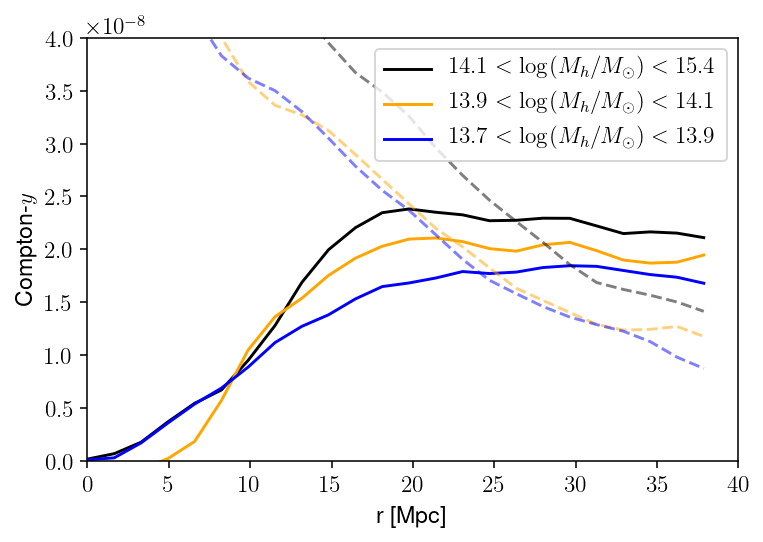

In [135]:
binned_y_hi_m2, r_hi = bin_profile(Cr_hi[:,2], .5, 5)
binned_y_med_m2, r_med = bin_profile(Cr_med[:,2], .5, 5)
binned_y_low_m2, r_low = bin_profile(Cr_low[:,2], .5, 5)

binned_y_hi_m0, r_hi = bin_profile(Cr_hi[:,0], .5, 5)
binned_y_med_m0, r_med = bin_profile(Cr_med[:,0], .5, 5)
binned_y_low_m0, r_low = bin_profile(Cr_low[:,0], .5, 5)

plt.plot(r_hi, binned_y_hi_m2, 'k', label='${:0.1f}<\log(M_h/M_\odot)<{:0.1f}$'.format(np.log10(him_minmass), np.log10(him_maxmass)))
plt.plot(r_med, binned_y_med_m2, 'orange', label='${:0.1f}<\log(M_h/M_\odot)<{:0.1f}$'.format(np.log10(midm_minmass),
                                                                                              np.log10(midm_maxmass)))
plt.plot(r_low, binned_y_low_m2, 'blue', label='${:0.1f}<\log(M_h/M_\odot)<{:0.1f}$'.format(np.log10(lowm_minmass), np.log10(lowm_maxmass)))

plt.plot(r_hi, binned_y_hi_m0, 'k', linestyle='--', alpha = 0.5)
plt.plot(r_med, binned_y_med_m0, 'orange', linestyle='--', alpha = 0.5)
plt.plot(r_low, binned_y_low_m0, 'blue', linestyle='--', alpha = 0.5)

plt.xlim([0,40])
plt.xlabel("r [Mpc]")
plt.ylim([0, .4e-7])
plt.ylabel("Compton-$y$")
plt.legend()
plt.savefig("/home/mlokken/actxdes_stacking/plots/meq0and2_massbins_pp_fullsky.png")
